In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os

import matplotlib.pyplot as plt
from dgl.data import BACommunityDataset
import networkx as nx
import torch_geometric
import dgl


In [4]:
%cd C:\\Users\\Yurt\\Documents\\Cambridge\\GNN\\gnn_explainability

C:\Users\Yurt\Documents\Cambridge\GNN\gnn_explainability


In [58]:
from src.model import *
from src.data import *
from src.explainer import *
from src.plot import *
from src.modify import *
from src.protgnn import *

In [6]:
ba_dataset = get_dataset("BAShapes")

Done loading data from cached files.


C:\Users\Yurt\anaconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
num_classes = len(set([int(i) for i in ba_dataset.y]))
num_features = ba_dataset.x.shape[-1]

In [8]:
epochs = 3000
dim = 20

## GCExplainer

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=num_features, dim=dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


In [10]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model)

[Train_loss:0.200215 Train_acc: 0.9732, Test_acc: 0.9071]: 100%|███████████████████| 3000/3000 [01:22<00:00, 36.44it/s]


In [11]:
gce_explainer = GCExplainer()

In [12]:
gce_explainer.learn_prototypes(model,ba_dataset)

C:\Users\Yurt\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yurt\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [13]:
gce_explainer.get_prediction(model,ba_dataset)

array([3, 3, 2, 3, 1, 2, 3, 2, 2, 2, 0, 2, 1, 0, 0, 2, 3, 3, 2, 3, 2, 0,
       0, 3, 1, 3, 0, 2, 2, 2, 0, 0, 3, 3, 3, 2, 2, 2, 2, 3, 0, 2, 0, 0,
       2, 2, 3, 0, 3, 2, 2, 3, 0, 3, 2, 2, 3, 1, 2, 2, 0, 1, 2, 0, 3, 3,
       3, 3, 2, 3, 0, 0, 0, 2, 0, 2, 2, 1, 3, 2, 0, 0, 2, 3, 2, 2, 2, 3,
       2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 1], dtype=int64)

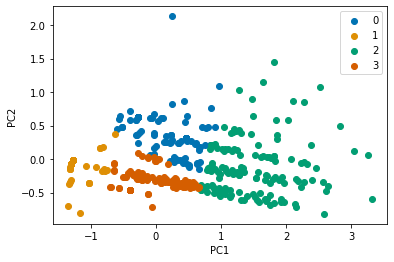

In [14]:
plot_kmeans_clusters(gce_explainer.kmeans,gce_explainer.initial_activations)

In [71]:
gce_explainer.get_prediction(model,identity(ba_dataset))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [75]:
gce_explainer.get_completeness(model,identity(ba_dataset))

0.9214285714285714

## ProtGNN

In [16]:
model = GCNNet_NC(num_features, num_classes, model_args).to(device)

In [17]:
model.load_state_dict(torch.load("../models/protgnn_bashapes.pt"))

FileNotFoundError: [Errno 2] No such file or directory: '../models/protgnn_bashapes.pt'

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-3)

In [19]:
model = train_model(300,model,device,ba_dataset,optimizer,test_model,get_outputs=lambda a: a[1])

[Train_loss:0.630263 Train_acc: 0.7161, Test_acc: 0.6643]: 100%|█████████████████████| 300/300 [00:25<00:00, 11.93it/s]


In [20]:
prot_explainer = ProtGNNExplainer()

In [21]:
prot_explainer.learn_prototypes(model,ba_dataset)

In [22]:
prot_explainer.get_prediction(model,ba_dataset)

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6, 10, 10, 10, 10,  6, 10,
       10, 10,  6, 10, 10, 10,  6, 10, 10,  6, 10, 10, 10, 10,  6, 10, 10,
       10, 10, 10, 10,  6, 10, 10, 10,  6, 10, 10, 10, 10,  6, 10, 10,  6,
       10, 10,  6, 10, 10,  6, 10, 10, 10,  6, 10, 10,  6, 10, 10,  6, 10,
       10,  6, 10, 10,  6, 10, 10,  6, 10, 10,  6, 10, 10,  6, 10, 10,  6,
       10, 10,  6, 10, 10,  6, 10, 10,  6, 10, 10,  6, 10, 10,  6, 10, 10,
        6, 10, 10,  6, 10, 10,  6, 10, 10,  6, 10, 10,  6, 10, 10,  6, 10,
       10,  6, 10, 10, 10,  3,  6, 10,  6, 10, 10,  6, 10, 10, 10, 10, 10,
       10,  6, 10, 10,  6, 10, 10, 10, 10, 10,  6, 10, 10,  6, 10, 10, 10,
       10,  6, 10,  6, 10,  6, 10, 10,  6, 10, 10,  6, 10, 10, 10, 10,  6,
       10, 10,  6, 10, 10, 10,  6, 10, 10,  6, 10, 10,  6, 10, 10,  6,  3,
       10, 10,  6, 10, 10

## CDM

In [49]:
model = GCN(num_features=num_features, dim=dim, num_classes=num_classes)

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-3)

In [51]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model,get_outputs=lambda a: a[1])

[Train_loss:5.440346 Train_acc: 0.9393, Test_acc: 0.8714]: 100%|███████████████████| 3000/3000 [01:00<00:00, 49.27it/s]


In [52]:
cdm_explainer = CDMExplainer()

In [53]:
cdm_explainer.learn_prototypes(model, ba_dataset)

In [54]:
cdm_explainer.get_prediction(model, ba_dataset)

Explanation class 0: feature0000000012 - acc. = 0.9357 - compl. = 1.0000
Explanation class 1: ~feature0000000010 & ~feature0000000011 & ~feature0000000012 & ~feature0000000013 & ~feature0000000014 - acc. = 0.9571 - compl. = 5.0000
Explanation class 2: feature0000000007 - acc. = 0.9643 - compl. = 1.0000
Explanation class 3: ~feature0000000010 & ~feature0000000012 & ~feature0000000014 & ~feature0000000016 - acc. = 0.9857 - compl. = 4.0000


{'0': {'explanation': 'feature0000000012',
  'explanation_accuracy': 0.9357142857142857,
  'explanation_complexity': 1},
 '1': {'explanation': '~feature0000000010 & ~feature0000000011 & ~feature0000000012 & ~feature0000000013 & ~feature0000000014',
  'explanation_accuracy': 0.9571428571428572,
  'explanation_complexity': 5},
 '2': {'explanation': 'feature0000000007',
  'explanation_accuracy': 0.9642857142857143,
  'explanation_complexity': 1},
 '3': {'explanation': '~feature0000000010 & ~feature0000000012 & ~feature0000000014 & ~feature0000000016',
  'explanation_accuracy': 0.9857142857142858,
  'explanation_complexity': 4}}

In [59]:
cdm_explainer.get_completeness(model, ba_dataset)

0.5452592551640624

In [60]:
cdm_explainer.get_concepts(model, ba_dataset)

tensor([[0.2475, 0.2475, 0.8837,  ..., 0.6495, 0.6513, 0.8804],
        [0.1545, 0.1545, 0.6845,  ..., 0.4238, 0.4246, 0.6796],
        [0.1840, 0.1840, 0.7812,  ..., 0.4575, 0.4582, 0.7750],
        ...,
        [0.0128, 0.0128, 0.1321,  ..., 0.0622, 0.0622, 0.1301],
        [0.0775, 0.0787, 0.1217,  ..., 0.5723, 0.5784, 0.1251],
        [0.9973, 0.9995, 0.5699,  ..., 0.9373, 0.9438, 0.5774]],
       grad_fn=<DivBackward0>)

## Adversary Methods

In [29]:
ba_aggressive = aggressive_adversary(ba_dataset,0.1)

In [30]:
ba_aggressive.edge_index.int()

tensor([[ 44,  49,  53,  ...,  15, 679, 517],
        [  0,   1,   2,  ...,  98, 448, 394]], dtype=torch.int32)

In [31]:
ba_conservative = conservative_adversary(ba_dataset, 'BAShapes', 0.1)

UnboundLocalError: local variable 'vertices' referenced before assignment

In [ ]:
ba_conservative.edge_index.int()

## Plot Prelim Results

In [ ]:
plot_metric('results', 'bashapes', 'Fidelity')